In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))
#TensorFlow version used: 2.4.1

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fx82p_er because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


TensorFlow version used: 2.4.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
# This is dim 1 setting
# Parameters settings
# Final time
T = 0.5

# Spatial dimensions
dim = 1
neuron = 40

# Number of equidistant intervals in time
N = 25

# Derive time step size and t_space
dt = T/N
t_space = np.linspace(0, T, N + 1)
x = np.ones(1)*0.3

#This is the window the we are concerning in the beginning
x_low_bd = -5.
x_up_bd = 5.

In [4]:
class BSDEModel(tf.keras.Model):
    def __init__(self, **kwargs):

        # Call initializer of tf.keras.Model
        super().__init__(**kwargs)

        # Create template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)

        # Create template of batch normalization layer
        _bn = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))

        # Initialize a list of networks approximating zi at t_i
        # zir:z real part
        # zii:z imaginary part
        self.yr = []
        self.yi = []
        self.zr = []
        self.zi = []

        #We create layers for yrpi, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.yr.append(this_grad)
        
        #We create layers for yrmi, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.yi.append(this_grad)

        #We create layers for zrpi, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.zr.append(this_grad)

        #We create layers for zrmi, from 0 to N-1
        for _ in range(N):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(2):
                this_grad.add(_dense(dim+neuron))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.Activation('tanh'))

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.zi.append(this_grad)

In [5]:
def draw_X_and_dW(num_sample, x, N):
    """ Function to draw num_sample many paths of the stochastic process X
    and the corresponding increments of simulated Brownian motions dW. """
    # x must be (num_sample,dim)
    dim = 1

    # Draw all increments of W at once
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_sample, dim, N)).astype(DTYPE)

    # Initialize the array X
    X = np.zeros((num_sample, dim, N+1), dtype=DTYPE)

    # Set starting point to x for each draw
    X[:, :, 0] = x

    for i in range(N):
        # This corresponds to the Euler-Maruyama Scheme
        X[:, :, i+1] = X[:, :, i] + 1 * dW[:, :, i]

    # Return simulated paths as well as increments of Brownian motion

    return X, dW

#X,dW = draw_X_and_dW(100,x)
#type(X)
#dW.shape

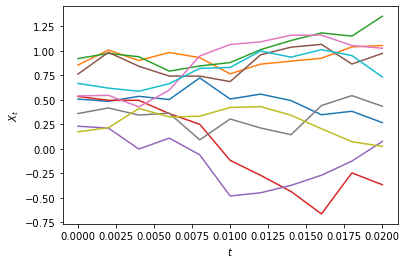

In [6]:
num_sample=10

# Draw 10 sample paths
X,dW = draw_X_and_dW(num_sample, np.random.rand(num_sample,1),10)

# Plot these paths
fig,ax = plt.subplots(1)
for i in range(num_sample):
    ax.plot(np.linspace(0, T/N, 10 + 1),X[i,0,:])
ax.set_xlabel('$t$')
ax.set_ylabel('$X_t$');

In [7]:
def simulate_Y_once(current_step, inp, model, fun_fr, fun_fi, fun_dgr, fun_dgi):
    """ This function performs the forward sweep through the network.
    Inputs:
        current_step - which step is now? from 0 to N-1.
        inp - (X, dW) - here we only need two steps X,dW, which is the initial value plus the one movement of Brownian motion
        model - model of neural network, contains
            - u0  - variable approximating u(0, x)
            - gradu0 - variable approximating nabla u(0, x)
            - gradui - list of NNs approximating the mapping: x -> nabla u(t_i, x)
        fun_f - function handle for cost function f
    """
    # Check the input current_step, we need it to be within 0 to N-1.
    if not (0 <= current_step <= N-1):
        raise ValueError(f"current step must be between 0 and N-1")

    X, dW = inp
    num_sample = X.shape[0]
    e_num_sample = tf.ones(shape=[num_sample, 1], dtype=DTYPE)
    # y approximation now
    yr_now = e_num_sample * model.yr[current_step](X[:,:,0])
    yi_now = e_num_sample * model.yi[current_step](X[:,:,0])

    # z approximation at now
    zr_now = e_num_sample * model.zr[current_step](X[:,:,0])
    zi_now = e_num_sample * model.zi[current_step](X[:,:,0])    

    for i in range(current_step,current_step+1):
        # Now we get the current_step+1 value bacause of the Stratonovich integral 
        if i == N-1:
            zr_next = fun_dgr(X[:, :, i-current_step+1])
            zi_next = fun_dgi(X[:, :, i-current_step+1])
        else:
            zr_next = model.zr[i+1](X[:, :, i-current_step+1])
            zi_next = model.zi[i+1](X[:, :, i-current_step+1])

        # Now we calculate the yrpi_next, yrmi_next
        eta1r = fun_fi(t_space[i],yr_now,yi_now) * dt
        eta2r = 0.5 * ((zr_next + zi_next) - (zr_now + zi_now)) * dW[:, :, i-current_step] + zr_now*dW[: , :, i-current_step]
        eta1i = -fun_fr(t_space[i],yr_now,yi_now) * dt 
        eta2i = -0.5 * ((zr_next - zi_next) - (zr_now - zi_now)) * dW[:, :, i-current_step] + zi_now*dW[:, :, i-current_step]

        # Compute new value approximations at t_{i+1}
        yr_now = yr_now + eta1r + eta2r
        yi_now = yi_now + eta1i + eta2i

    return yr_now,yi_now

In [8]:
def loss_fn_till_end(current_step, inp, model, fun_fr, fun_fi, fun_gr, fun_gi, fun_dgr, fun_dgi):
    """ This function computes the mean-squarred error of the difference of Y_T and g(X_T)
    Inputs:
        current_step - which step is now? from 0 to N-1.
        inp - (X, dW)
        model - model of neural network containing u0, gradu0, gradui
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """
    # Check the input current_step, we need it to be within 0 to N-1.
    if not (0 <= current_step <= N-1):
        raise ValueError(f"current step must be between 0 and N-1")
    
    X, _ = inp

    # Forward pass to compute value estimates
    yr_pred,yi_pred = simulate_Y_once(current_step, inp, model, fun_fr,fun_fi,fun_dgr, fun_dgi)

    # Final time condition, i.e., evaluate g(X_T)
    if current_step == N-1:
        yr_true = fun_gr(X[:, :, 1])
        yi_true = fun_gi(X[:, :, 1])
        zr_true = fun_dgr(X[:, :, 1])
        zi_true = fun_dgi(X[:, :, 1])
    else:
        yr_true = model.yr[current_step+1](X[:,:,1])
        yi_true = model.yi[current_step+1](X[:,:,1])
        zr_true = model.zr[current_step+1](X[:, :, 1])
        zi_true = model.zi[current_step+1](X[:, :, 1])
    
# Compute mean squared error
    yr_diff = yr_true - yr_pred
    yi_diff = yi_true - yi_pred
#     zr_diff = zr_true - zr_pred
#     zi_diff = zi_true - zi_pred
    # zr_diff = tf.cast(zr_true, tf.float32) - zr_pred
    # zi_diff = tf.cast(zi_true, tf.float32) - zi_pred
    # weight = tf.minimum((tf.abs(yr_diff/yi_diff) + tf.abs(zr_diff/zi_diff)) * 0.5 , 2)
    loss = tf.reduce_mean(tf.square(yr_diff) + tf.square(yi_diff))

    return loss

In [9]:
# Define cost function fr fi
def fun_fi(t, yr, yi):
    return  0.0
def fun_fr(t, yr, yi):
    return  0.0

# Set terminal value function g
def fun_gr(x):
    return tf.math.cos(tf.math.sqrt(2.)*x)
def fun_gi(x):
    return tf.math.sin(tf.math.sqrt(2.)*x)

def fun_dgr(x):
    return -tf.math.sqrt(2.)*tf.math.sin(tf.math.sqrt(2.)*x)
def fun_dgi(x):
    return tf.math.sqrt(2.)*tf.math.cos(tf.math.sqrt(2.)*x)
# Set learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100,1000],[1e-2,.8e-2,.5e-2])
#lr = 1e-2
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = BSDEModel()

history = []

In [10]:
@tf.function
def compute_grad(current_step, inp, model, fun_fr, fun_fi, fun_gr, fun_gi, fun_dgr, fun_dgi):
    """ This function computes the gradient of the loss function w.r.t.
    the trainable variables theta.
    Inputs:
        inp - (X, dW)
        model - model of neural network containing u0, gradu0, gradui
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """
    current_step_trainable_variables = model.yr[current_step].trainable_variables+model.yi[current_step].trainable_variables+model.zr[current_step].trainable_variables+model.zi[current_step].trainable_variables
    with tf.GradientTape() as tape:
        loss = loss_fn_till_end(current_step, inp, model, fun_fr,fun_fi, fun_gr, fun_gi,fun_dgr, fun_dgi)
    
    grad = tape.gradient(loss, current_step_trainable_variables)
    return loss, grad

In [11]:
t0 = time()
batch_size = 4096
random_pts = 1024
num_epochs_terminal = 31
num_epochs_general = 31
save_point = 30
#we require these two epoch numbers to be equal and of the form xx1.

In [12]:
import os
import re

def find_largest_epoch_and_smallest_step(directory):
    # Regular expression to match the required filename pattern
    pattern = re.compile(r'step_(\d+)_num_epochs_(\d+)')
    
    # Variables to keep track of the smallest step and largest epoch for that step
    min_step = float('inf')
    max_epoch = 0
    found = False
    
    # Loop over each file in the directory
    for filename in os.listdir(directory):
        match = pattern.search(filename)
        if match:
            step = int(match.group(1))
            epoch = int(match.group(2))
            
            # Check if this file has a smaller step or if it matches the current smallest step
            if step < min_step:
                min_step = step
                max_epoch = epoch
                found = True
            elif step == min_step:
                max_epoch = max(max_epoch, epoch)
    
    # Return the result based on whether we found any matching files
    if found:
        return max_epoch, min_step
    else:
        return 0, N-1

current_directory = os.getcwd()
now_epoch_step = find_largest_epoch_and_smallest_step(current_directory)
print(now_epoch_step)

(30, 0)


In [13]:
if not(now_epoch_step[0] == 0 and now_epoch_step[1] == N-1):
    for current_step in range(now_epoch_step[1]+1,N):
        # Create an array of x values from -2π to 2π
        model.yr[current_step].load_weights(f'yr_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
        model.yi[current_step].load_weights(f'yi_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
        model.zr[current_step].load_weights(f'zr_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
        model.zi[current_step].load_weights(f'zi_current_step_{current_step}_num_epochs_{num_epochs_terminal-1}.h5')
    current_step = now_epoch_step[1]
    model.yr[current_step].load_weights(f'yr_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')
    model.yi[current_step].load_weights(f'yi_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')
    model.zr[current_step].load_weights(f'zr_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')
    model.zi[current_step].load_weights(f'zi_current_step_{current_step}_num_epochs_{now_epoch_step[0]}.h5')


In [14]:

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100,1000],[4e-2,1e-2,.5e-2])

# #Initialize header of output
# print('Step      Iter      Loss        x     t_real   t_img    p_real   p_img   |  Time    Stepsize')

# for current_step in reversed(range(now_epoch_step[1]+1)):
#     if current_step == N-1:
#         num_epochs = num_epochs_terminal
#     else:
#         num_epochs = num_epochs_general
# #         model.yrpi[current_step].load_weights('yrpi_last.h5')
# #         model.yrmi[current_step].load_weights('yrmi_last.h5')
# #         model.zrpi[current_step].load_weights('zrpi_last.h5')
# #         model.zrmi[current_step].load_weights('zrmi_last.h5')
#     if current_step == now_epoch_step[1]:
#         for i in range(now_epoch_step[0],num_epochs):
#             for _ in range(random_pts):
#                 x = (np.random.rand(batch_size,1)-1/2)*10
#                 # Each epoch we draw a batch of 64 random paths
#                 X, dW = draw_X_and_dW(batch_size, x, N-current_step)
#                 # Compute the loss as well as the gradient
#                 loss, grad = compute_grad(current_step,(X, dW), model, fun_fr,fun_fi, fun_gr,fun_gi,fun_dgr, fun_dgi)
#                 current_step_trainable_variables = model.yr[current_step].trainable_variables+model.yi[current_step].trainable_variables+model.zr[current_step].trainable_variables+model.zi[current_step].trainable_variables
#                 optimizer.apply_gradients(zip(grad, current_step_trainable_variables))

#                 # Get current Y_0 \approx u(0,x)
#                 yr = model.yr[current_step](x)
#                 yi = model.yi[current_step](x)
#                 yr = yr.numpy()[0,0]
#                 yi = yi.numpy()[0,0]

#                 currtime = time() - t0
#                 hentry = (current_step, i, loss.numpy(), x[0,0], 1/np.cosh(x-(N-current_step)*T/N)[0,0]*np.cos(x)[0,0], 1/np.cosh(x-(N-current_step)*T/N)[0,0]*np.sin(x)[0,0], yr, yi, currtime, lr(i))
#                 history.append(hentry)
#                 if i%save_point == 0:
#                         print('{:5d} {:5d} {:12.4f} {:8.4f} {:8.4f} {:8.4f}  {:8.4f} {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))        
#             if i%save_point == 0:
#                 print('Step      Iter      Loss        x     t_real   t_img    p_real   p_img   |  Time    Stepsize')
#             if i%save_point == 0:
#                 model.yr[current_step].save_weights(f'yr_current_step_{current_step}_num_epochs_{i}.h5')
#                 model.yi[current_step].save_weights(f'yi_current_step_{current_step}_num_epochs_{i}.h5')
#                 model.zr[current_step].save_weights(f'zr_current_step_{current_step}_num_epochs_{i}.h5')
#                 model.zi[current_step].save_weights(f'zi_current_step_{current_step}_num_epochs_{i}.h5')
#         #plot real part graph:
#         x = np.linspace(x_low_bd, x_up_bd, 200)
#         x = x.reshape(200,1)
#         # Compute the sine of each x value
#         y = model.yr[current_step](x)
#         j = np.cos(np.sqrt(2)*x-(N-current_step)*T/N)

#         # Create the plot
#         plt.figure(figsize=(8, 4))  # Set the figure size
#         plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
#         plt.plot(x, j, label='true') 

#         # Add a title and labels
#         plt.title('Plot of real part')

#         # Add a legend
#         plt.legend()

#         # Show the plot
#         current_time = datetime.datetime.now()
#         formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
#         filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_real_{formatted_time}_step_{current_step}_yz.png"
#         plt.savefig(filename)
#         print(f"Plot saved as {filename}")

#         #plot img part graph:
#         y = model.yi[current_step](x)
#         j =  np.sin(np.sqrt(2)*x-(N-current_step)*T/N)

#         # Create the plot
#         plt.figure(figsize=(8, 4))  # Set the figure size
#         plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
#         plt.plot(x, j, label='true') 

#         # Add a title and labels
#         plt.title('Plot of img part')

#         # Add a legend
#         plt.legend()

#         # Show the plot
#         current_time = datetime.datetime.now()
#         formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
#         filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_img_{formatted_time}_step_{current_step}_yz.png"
#         plt.savefig(filename)
#         print(f"Plot saved as {filename}")
        
#     else:
#         for i in range(num_epochs):
#             for _ in range(random_pts):
#                 x = (np.random.rand(batch_size,1)-1/2)*10
#                 # Each epoch we draw a batch of 64 random paths
#                 X, dW = draw_X_and_dW(batch_size, x, N-current_step)
#                 # Compute the loss as well as the gradient
#                 loss, grad = compute_grad(current_step,(X, dW), model, fun_fr,fun_fi, fun_gr,fun_gi,fun_dgr, fun_dgi)
#                 current_step_trainable_variables = model.yr[current_step].trainable_variables+model.yi[current_step].trainable_variables+model.zr[current_step].trainable_variables+model.zi[current_step].trainable_variables
#                 optimizer.apply_gradients(zip(grad, current_step_trainable_variables))

#                 # Get current Y_0 \approx u(0,x)
#                 yr = model.yr[current_step](x)
#                 yi = model.yi[current_step](x)
#                 yr = yr.numpy()[0,0]
#                 yi = yi.numpy()[0,0]

#                 currtime = time() - t0
#                 hentry = (current_step, i, loss.numpy(), x[0,0], np.cos(x-(N-current_step)*T/(2*N))[0,0], np.sin(x-(N-current_step)*T/(2*N))[0,0], yr, yi, currtime, lr(i))
#                 history.append(hentry)
#                 if i%save_point == 0:
#                         print('{:5d} {:5d} {:12.4f} {:8.4f} {:8.4f} {:8.4f}  {:8.4f} {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))        
#             if i%save_point == 0:
#                 print('Step      Iter      Loss        x     t_real   t_img    p_real   p_img   |  Time    Stepsize')
#             if i%save_point == 0:
#                 model.yr[current_step].save_weights(f'yr_current_step_{current_step}_num_epochs_{i}.h5')
#                 model.yi[current_step].save_weights(f'yi_current_step_{current_step}_num_epochs_{i}.h5')
#                 model.zr[current_step].save_weights(f'zr_current_step_{current_step}_num_epochs_{i}.h5')
#                 model.zi[current_step].save_weights(f'zi_current_step_{current_step}_num_epochs_{i}.h5')
#         #plot real part graph:
#         x = np.linspace(x_low_bd, x_up_bd, 200)
#         x = x.reshape(200,1)
#         # Compute the sine of each x value
#         y = model.yr[current_step](x)
#         j = np.cos(np.sqrt(2)*x-(N-current_step)*T/N)

#         # Create the plot
#         plt.figure(figsize=(8, 4))  # Set the figure size
#         plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
#         plt.plot(x, j, label='true') 

#         # Add a title and labels
#         plt.title('Plot of real part')

#         # Add a legend
#         plt.legend()

#         # Show the plot
#         current_time = datetime.datetime.now()
#         formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
#         filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_real_{formatted_time}_step_{current_step}_yz.png"
#         plt.savefig(filename)
#         print(f"Plot saved as {filename}")

#         #plot img part graph:
#         y = model.yi[current_step](x)
#         j = np.sin(np.sqrt(2)*x-(N-current_step)*T/N)

#         # Create the plot
#         plt.figure(figsize=(8, 4))  # Set the figure size
#         plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
#         plt.plot(x, j, label='true') 

#         # Add a title and labels
#         plt.title('Plot of img part')

#         # Add a legend
#         plt.legend()

#         # Show the plot
#         current_time = datetime.datetime.now()
#         formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
#         filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_img_{formatted_time}_step_{current_step}_yz.png"
#         plt.savefig(filename)
#         print(f"Plot saved as {filename}")
        

In [15]:
# for current_step in range(N):
#     # Create an array of x values from -2π to 2π
#     # model.yr[current_step].load_weights(f'yr_current_step_{current_step}_num_epochs_200.h5')
#     # model.yi[current_step].load_weights(f'yi_current_step_{current_step}_num_epochs_200.h5')
#     # model.zr[current_step].load_weights(f'zr_current_step_{current_step}_num_epochs_200.h5')
#     # model.zi[current_step].load_weights(f'zi_current_step_{current_step}_num_epochs_200.h5')

#     x = np.linspace(x_low_bd, x_up_bd, 200)
#     x = x.reshape(200,1)
#     # Compute the sine of each x value
#     y = model.yr[current_step](x)
#     j = np.cos(x-(N-current_step)*T/(2*N))

#     # Create the plot
#     plt.figure(figsize=(8, 4))  # Set the figure size
#     plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
#     plt.plot(x, j, label='true') 

#     # Add a title and labels
#     plt.title('Plot of real part')

#     # Add a legend
#     plt.legend()

#     # Show the plot
#     current_time = datetime.datetime.now()
#     formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
#     filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_real_{formatted_time}_step_{current_step}_yz.png"
#     plt.savefig(filename)
#     print(f"Plot saved as {filename}")

In [16]:
# for current_step in range(N):
#     # Create an array of x values from -2π to 2π
#     x = np.linspace(x_low_bd, x_up_bd, 200)
#     x = x.reshape(200,1)
#     # Compute the sine of each x value
#     y = model.yi[current_step](x)
#     j = np.sin(x-(N-current_step)*T/(2*N))

#     # Create the plot
#     plt.figure(figsize=(8, 4))  # Set the figure size
#     plt.plot(x, y, label='predicted(x)')  # Plot x against sin(x)
#     plt.plot(x, j, label='true') 

#     # Add a title and labels
#     plt.title('Plot of img part')

#     # Add a legend
#     plt.legend()

#     # Show the plot
#     current_time = datetime.datetime.now()
#     formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")
#     filename = f"plot_T_{T}_N_{N}_neuron_{neuron}_img_{formatted_time}_step_{current_step}_yz.png"
#     plt.savefig(filename)
#     print(f"Plot saved as {filename}")

In [17]:
x = np.array([0])
x = x.reshape(1,1)
u_r = model.yr[0](x)
u_i = model.yi[0](x)
print(u_r)
print(u_i)

tf.Tensor([[0.8745007]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.46954277]], shape=(1, 1), dtype=float32)
